# Mushroom Classifier

## Introduction and Summary

## Introduction

This project aims to develop a robust model capable of predicting the genus of a mushroom based solely on its image. The primary motivation behind this initiative is to enhance mushroom safety by providing mushroom enthusiasts with a quick and reliable tool for identifying the genus of a mushroom before consumption, thereby reducing the risk of mushroom poisoning.

### Summary

Throughout the project, a comprehensive Deep Learning Framework was devised. This framework encompassed crucial stages such as data preprocessing, visual data augmentation, feature generation utilizing pre-trained architectures, mushroom classification using these features, and model fine-tuning. The experimentation phase involved testing various architectures and configuration options to optimize model performance. The outcome of these efforts is a mushroom classifier achieving an impressive accuracy of 84.5%, demonstrating its effectiveness in predicting the genus of mushrooms through image analysis.

**Imports:**

In [6]:
%reload_ext autoreload
%autoreload 1
from model_files.model import MushroomClassifier,MushroomDataModule, MushroomTuner
from IPython.display import Image as Image_display
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import cv2
import joblib
import numpy as np
import torch
import pytorch_lightning as ptl
from PIL import Image
import model_files.tuning as tunes
from model_files.explainer import explain_model
from ray import tune
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.search.optuna import OptunaSearch
from PIL import Image
from ray import train
from sklearn.metrics import classification_report
from IPython.display import clear_output
%aimport model_files.explainer
%aimport model_files.tuning
%aimport model_files.model

**Download the data:**

**Unzip the data and remove redundant files:**

**Settings:**

In [2]:
BASE_FIG_SIZE = (8.5, 5)
BASE_DIR = os.getcwd()

## Exploratory Data Analysis

**Setting up a data loader for the eda:**

In [3]:
eda_data_module = MushroomDataModule()
eda_data_module.setup()
eda_loader = eda_data_module.train_dataloader()

### Sample Overview

**Number of samples for each genus:**

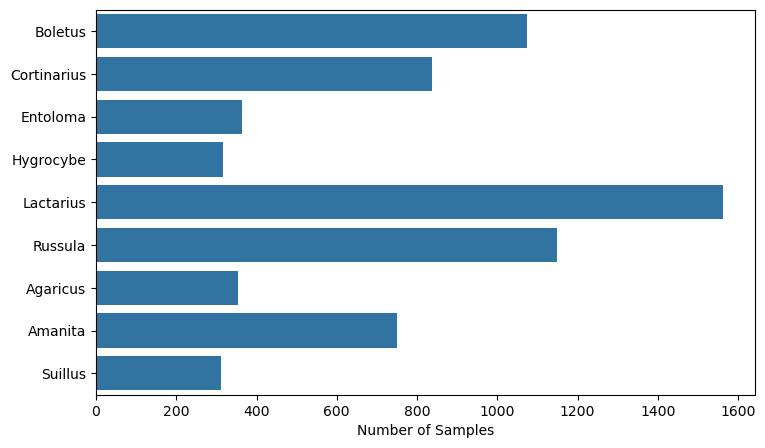

In [4]:
files = os.listdir("Mushrooms")
genuses = [file for file in files]
genus_data_count = {}
for genus in genuses:
    pics = os.listdir(f"Mushrooms/{genus}")
    genus_data_count[genus] = len([pic for pic in pics])
genus_data_count
fig_data_count, ax_data_count = plt.subplots(figsize=BASE_FIG_SIZE)
sns.barplot(genus_data_count, orient="y", ax=ax_data_count)
ax_data_count.set_xlabel("Number of Samples")
plt.show()

**A visual representation of a sample from each class:**

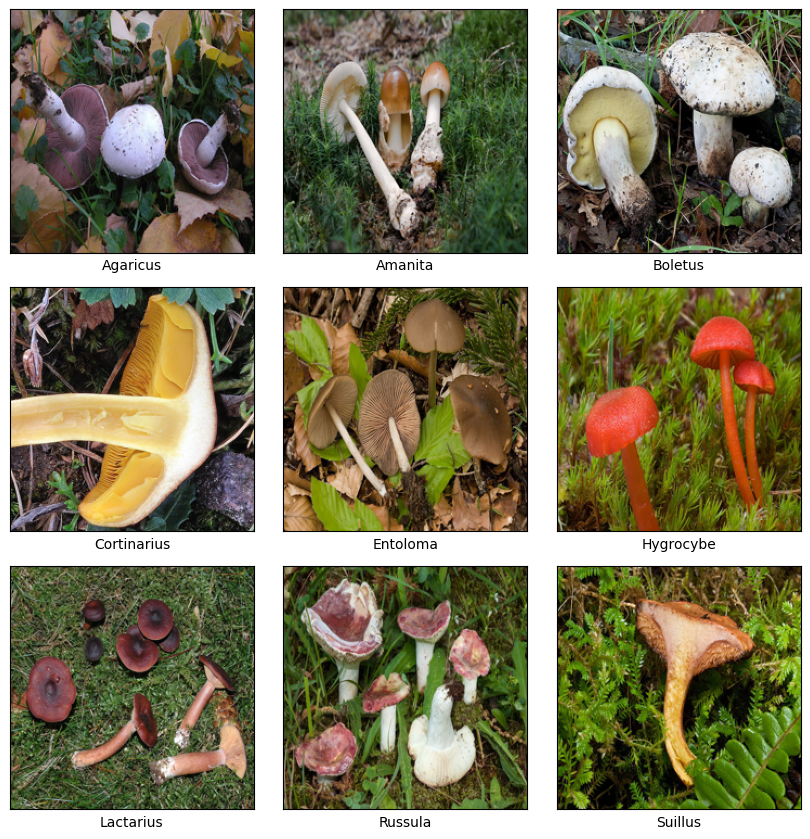

In [5]:
images = pl.DataFrame(eda_loader.dataset.dataset.samples, schema=["path", "class"])
class_dict = {
    item: key for key, item in eda_loader.dataset.dataset.class_to_idx.items()
}
fig_sample, ax_sample = plt.subplots(3, 3, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[0]))
ax_sample = ax_sample.flatten()
for i in range(9):
    path = images.filter(pl.col("class") == i).sample(1)["path"].item()
    image = Image.open(path)
    image = image.resize((225, 225))
    ax_sample[i].imshow(image)
    ax_sample[i].set_xlabel(class_dict[i])
    ax_sample[i].set_xticks([])
    ax_sample[i].set_yticks([])
plt.tight_layout(w_pad=0.1)

### Image Dimensions

**Getting image dimensions:**

In [6]:
sizes = {}
for genus in genus_data_count.keys():
    sizes[genus] = pl.DataFrame(
        schema={"name": str, "height": int, "width": int, "channels": int}
    )
    for img_name in os.listdir(f"Mushrooms/{genus}"):
        img = cv2.imread(f"Mushrooms/{genus}/{img_name}")
        height, width, channels = img.shape
        extend_df = pl.DataFrame(
            {"name": img_name, "height": height, "width": width, "channels": channels}
        )
        sizes[genus] = sizes[genus].extend(extend_df)

Premature end of JPEG file


**Image dimension distribution by genus:**

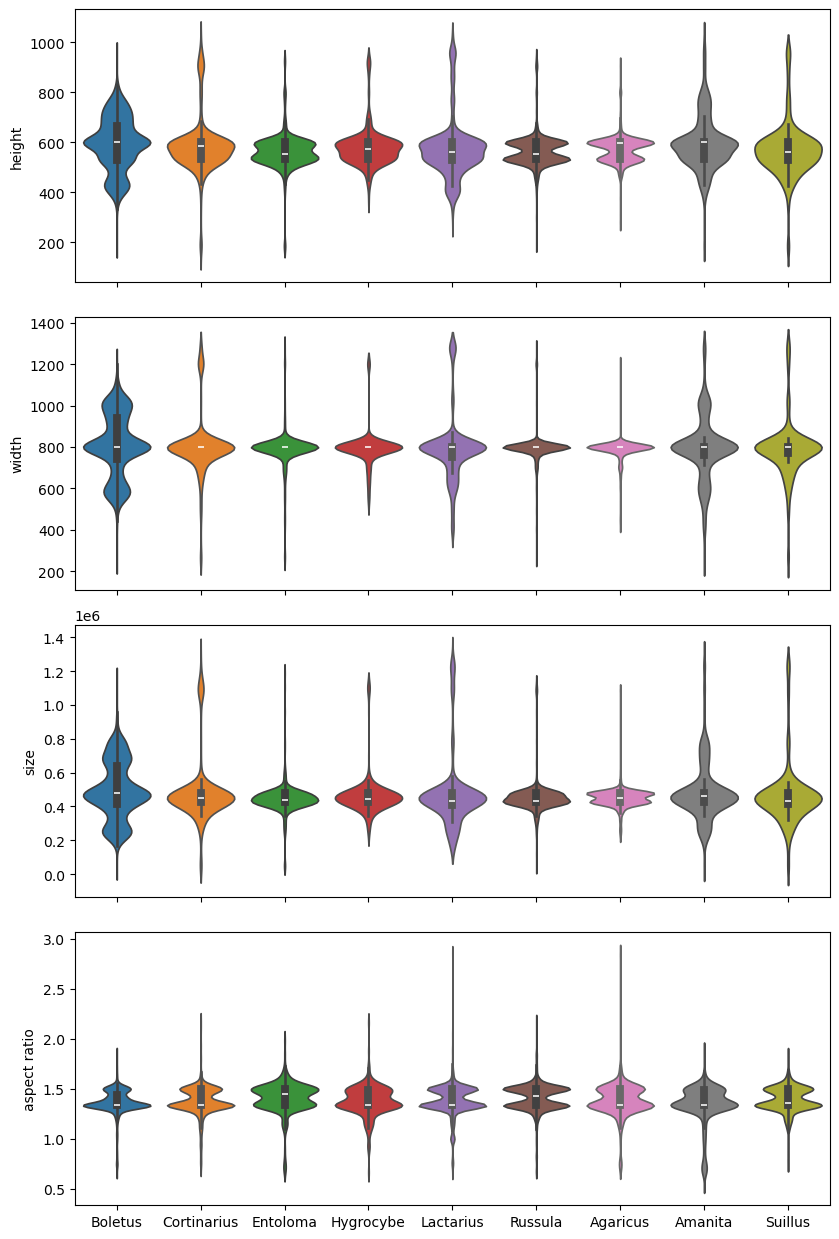

In [7]:
fig_sizes, ax_sizes = plt.subplots(
    4, 1, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 2.5), sharex=True
)
for i, genus in enumerate(sizes.keys()):
    sns.violinplot(y=sizes[genus]["height"], x=i, ax=ax_sizes[0])
    sns.violinplot(y=sizes[genus]["width"], x=i, ax=ax_sizes[1])
    sns.violinplot(
        y=sizes[genus]
        .select((pl.col("height") * pl.col("width")).alias("size"))
        .to_series(),
        x=i,
        ax=ax_sizes[2],
    )
    sns.violinplot(
        y=sizes[genus]
        .select((pl.col("width") / pl.col("height")).alias("aspect ratio"))
        .to_series(),
        x=i,
        ax=ax_sizes[3],
    )

ax_sizes[3].set_xticks(ticks=np.arange(len(sizes)), labels=sizes.keys())
plt.tight_layout()
plt.show()

## Model Setup and Option Trials:

**Setting up a logger for tensorbord:**

In [8]:
tb_logger = ptl.loggers.TensorBoardLogger("logs")

**Early stopping and fine-tunning callback options:**

In [9]:
early_stopping_config = {
    "monitor": "val_loss",
    "patience": 8,
    "mode": "min",
    "min_delta": 0.001,
}
fine_tuning_config = {
    "unfreeze_at_epoch": tune.randint(5, 11),
    "tuning_lr": tune.loguniform(1e-7, 1e-3),
}

**Setting up a trainable for option/hyper-parameter tuning with ray-tune:**

In [10]:
stopper = MaximumIterationStopper(1)
tuner = tune.Tuner(
    trainable=tune.with_resources(
        tune.with_parameters(
            tunes.TrainableP2L,
            model=MushroomClassifier,
            dm=MushroomDataModule,
            metric="val_loss",
            logger=tb_logger,
        ),
        resources={"CPU": 2, "GPU": 1},
    ),
    run_config=train.RunConfig(
        stop=stopper,
        storage_path=f"{BASE_DIR}/logs/ray/",
        name="tunning",
        checkpoint_config=train.CheckpointConfig(
            checkpoint_at_end=False,
        ),
    ),
    tune_config=tune.TuneConfig(
        search_alg=OptunaSearch(),
        mode="min",
        metric="score",
        num_samples=50,
    ),
    param_space={
        "batch_size": tune.randint(32, 128),
        "img_size": 224,
        "max_epochs": 22,
        "learning_rate": tune.loguniform(0.00001, 0.01),
        "num_classes": 9,
        "architecture": tune.choice(["squeezenet", "resnet18", "google", "shufflenet"]),
        "optimizer": tune.choice(["adam", "sgd"]),
        "l2": tune.loguniform(1e-6, 1),
        "early_stopping_params": early_stopping_config,
        "fine_tuning_params": fine_tuning_config,
        "base_dir": BASE_DIR,
    },
)

In this single step the best architecture, optimizer, preprocessing and model options are selected. The tuning is performed using ray-tune class API, on a single GPU. 50 trials are run and the best one is selected by the lowest loss (cross entropy). In this stage the options are as follows:

1. Preprocessing:
    * Batch Size 32-128
2. Optimizers:
    * Optimizer: either Adam or Stochastic gradient descent
    * l2 penalty: $1e^{-6}$ to $1$
3. Architectures:
    * ResNet18/SqueezeNet/GoogLeNet
4. Model Parameters:
    * Learning Rate: $1e^{-6}$ to $1e^{-2}$
5. Fine-tuning:
    * Epoch to begin fine-tuning: 5-11
    * Fine-tuning learning rate: $1e^{-7}$ to $1e^{-3}$

**Process Schema:**

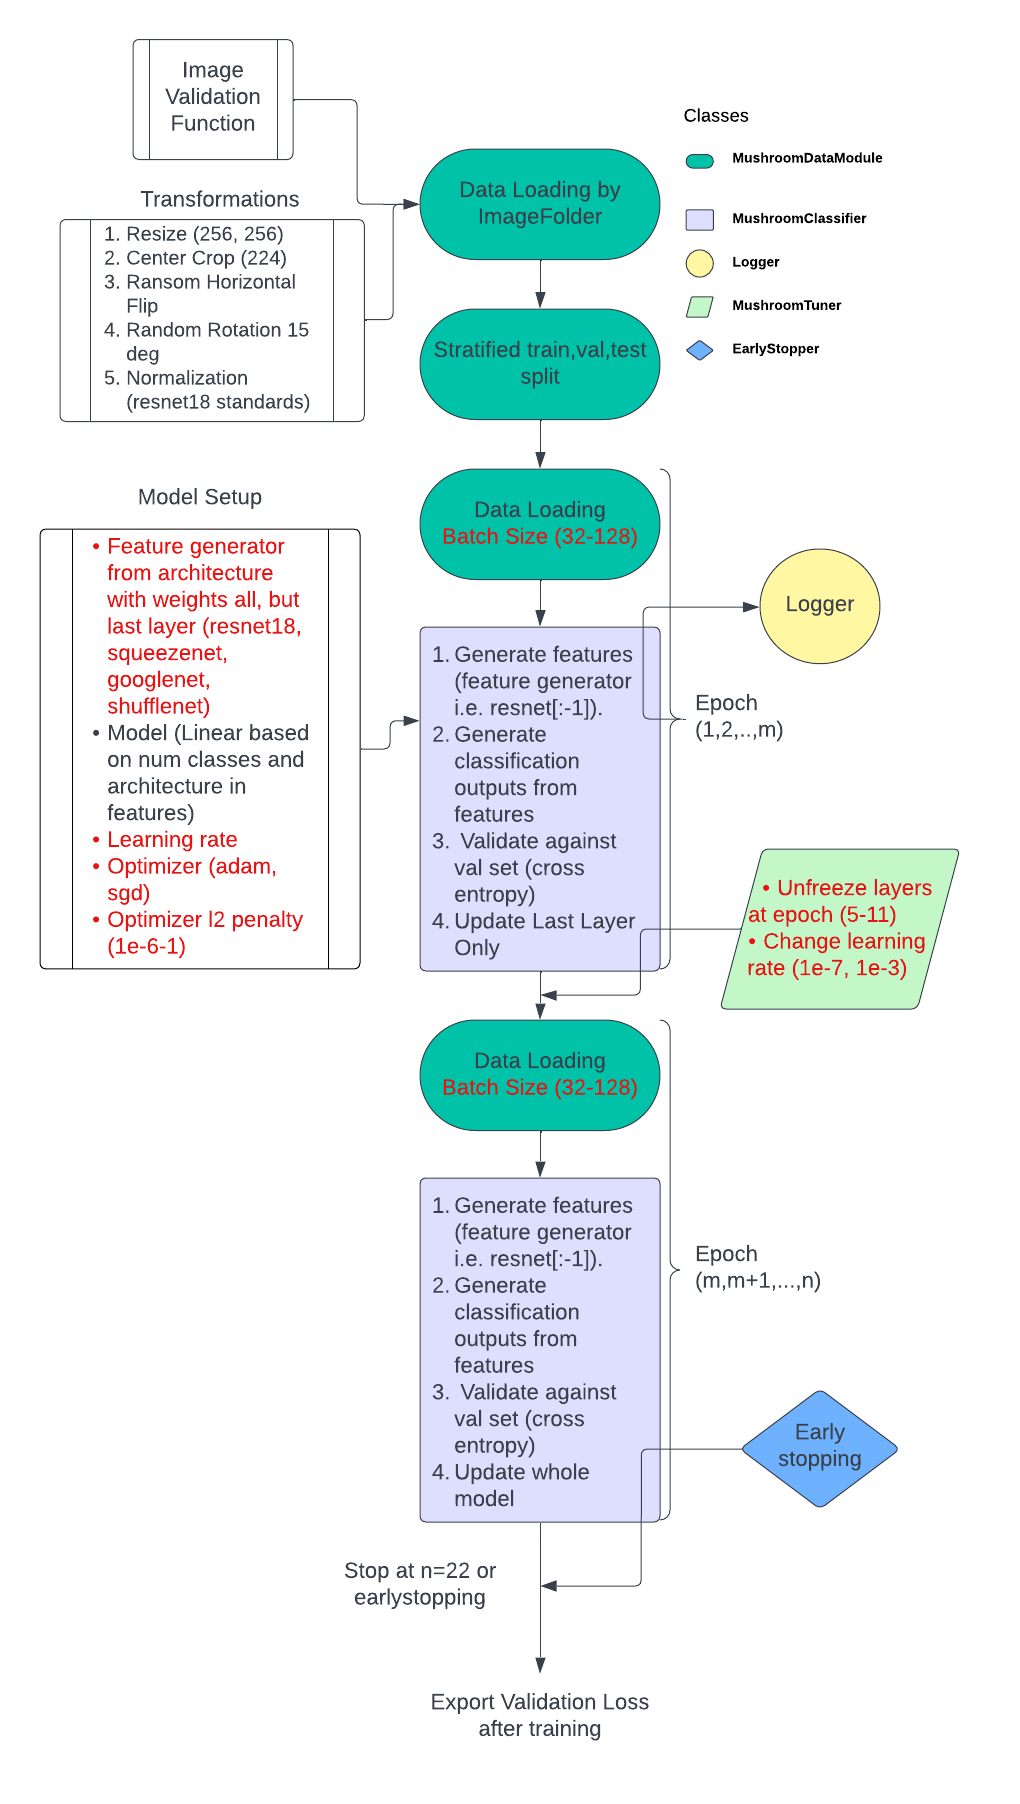

In [7]:
Image_display("temp/shroom_classfier.png")

**Running the option selection procedure:**

**Load results:**

In [14]:
best_params = joblib.load("temp/best_params.joblib")
best_params

{'batch_size': 91,
 'img_size': 224,
 'max_epochs': 22,
 'learning_rate': 0.006614074711373294,
 'num_classes': 9,
 'architecture': 'shufflenet',
 'optimizer': 'adam',
 'l2': 1.9157486673532663e-06,
 'early_stopping_params': {'monitor': 'val_loss',
  'patience': 8,
  'mode': 'min',
  'min_delta': 0.001},
 'fine_tuning_params': {'unfreeze_at_epoch': 9,
  'tuning_lr': 8.250702202020597e-05},
 'base_dir': '/home/gediminas/Documents/turing_projects/module4_s1/gskvar-DL.1.5'}

The best results were achieved using the shufflenet backbone, 9 initial training epochs with a learning rate of 8.3e-5 followed by model fine-tuning at the learning rate of 1.9e-6

**View results in tensorboard:**

In [12]:
%load_ext tensorboard

**Initiating model and data module instances with the best parameters and fitting the model:**

**Re-fitting the model for the best number of epochs:**

**Training curve of the final model:**

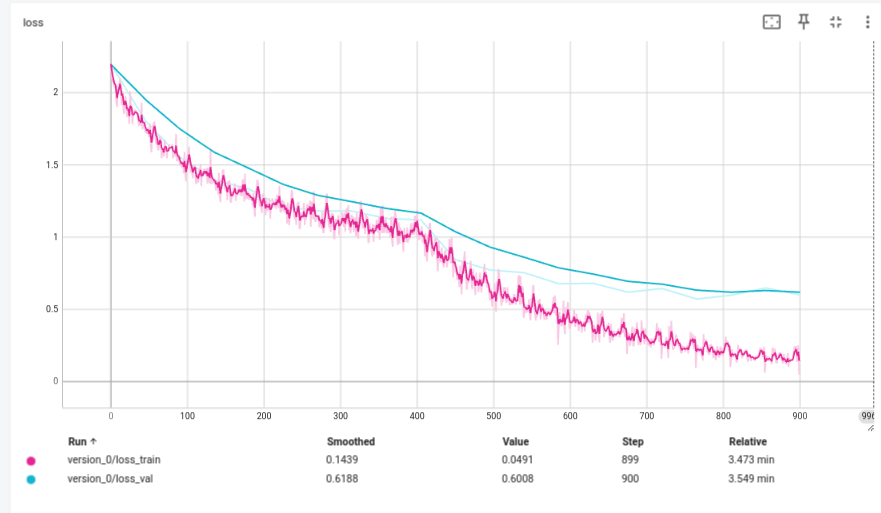

In [8]:
Image_display("temp/tb_logs.png")

**Loading the trained model:**

In [17]:
trainer, best_model, best_dm = joblib.load("temp/best_model.joblib")

## Model Evaluation

**Testing the model:**

In [18]:
trainer.test(best_model, best_dm, verbose=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8451228737831116
        test_loss           0.46871915459632874
 test_weighted_f1_score     0.8463259935379028
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.46871915459632874,
  'test_accuracy': 0.8451228737831116,
  'test_weighted_f1_score': 0.8463259935379028}]

**Loading test data:**

In [22]:
test_loader = best_dm.test_dataloader()

**Making prediction on the test set:**

In [24]:
# Predictions
predictions = trainer.predict(best_model, test_loader)
clear_output()
# Moving to a Data Frame
predictions_all = torch.cat(predictions, dim=0)
predictions_rounded = torch.argmax(predictions_all, dim=1)
predictions_rounded = pl.DataFrame(predictions_rounded.numpy(), schema=["prediction"])
predictions_rounded = predictions_rounded.with_columns(
    pl.DataFrame(
        [test_loader.dataset.dataset.samples[i] for i in test_loader.dataset.indices]
    )[:, 1].alias("true")
)

**Classification report:**

In [25]:
print(
    classification_report(
        predictions_rounded["true"], predictions_rounded["prediction"]
    )
)

              precision    recall  f1-score   support

           0       0.78      0.75      0.76        71
           1       0.82      0.88      0.85       150
           2       0.90      0.95      0.92       215
           3       0.82      0.78      0.80       167
           4       0.86      0.77      0.81        73
           5       0.93      0.84      0.88        63
           6       0.83      0.90      0.87       313
           7       0.87      0.82      0.85       229
           8       0.81      0.71      0.76        62

    accuracy                           0.85      1343
   macro avg       0.85      0.82      0.83      1343
weighted avg       0.85      0.85      0.85      1343



### Model Explanation

**New trainer instance for the explainer:**

In [37]:
trainer_fresh, _, _ = tunes.config_trainer_model_dm(
    best_params, MushroomClassifier, MushroomDataModule
)
clear_output()

**Calculate and plot LIME explanations:**

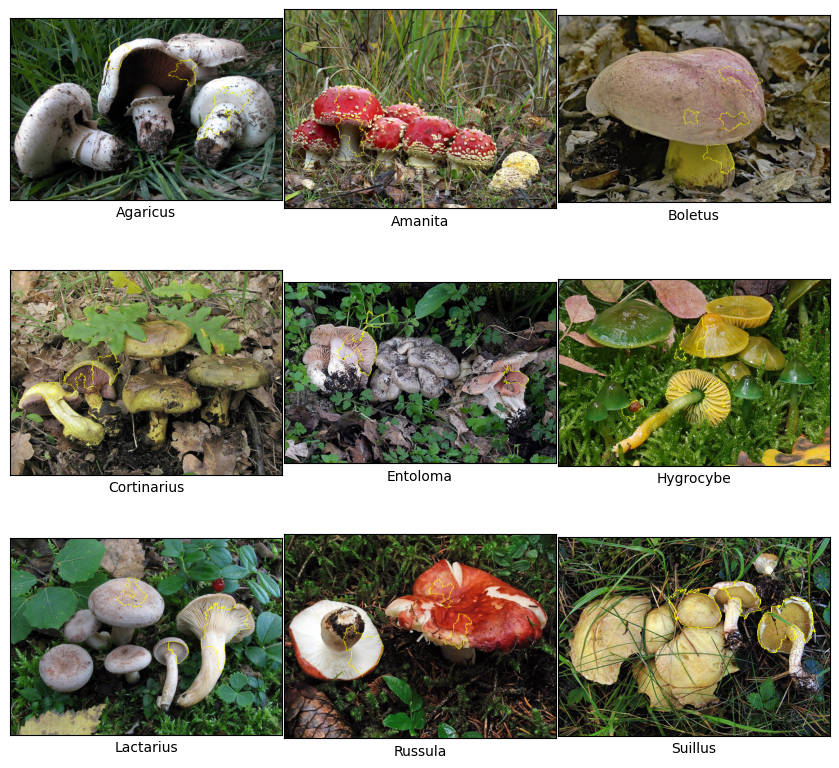

In [46]:
fig_explain, ax_explain = plt.subplots(
    3, 3, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[0])
)
ax_explain = ax_explain.flatten()
for i in np.arange(9):
    path = images.filter(pl.col("class") == i).sample(1)["path"].item()
    im = explain_model(
        path,
        trainer_fresh,
        best_model,
        best_dm.transform,
        return_img=True,
        n_samples=1000,
    )
    ax_explain[i].imshow(im)
    ax_explain[i].set_xlabel(class_dict[i])
    ax_explain[i].set_xticks([])
    ax_explain[i].set_yticks([])
plt.tight_layout(w_pad=0.1, h_pad=0.1)
plt.show()

## Conclusion
* The model is able to predict the genus of a given mushroom with an overall accuracy of 84%
* The model mostly relies on features that represent the actual mushroom and not the background

### Further Improvements
* Oversampling of the minority class using data Augmentation
* Test out deeper pre-trained architectures
* Implement sequential unfreezing of layers instead of a two-step fine-tuning